# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Advanced-Sections: Homework 3 - Echo-State Reservoir Computing (AKA HW6-209)




**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

In [4]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)
import os
import pathlib
working_dir = pathlib.Path().absolute()
# Uncomment the line below to help debug if the path to included images don't show
#print(working_dir)
os.chdir(working_dir)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit. (Exception - you may skip the cells where you train neural networks, running the cells which load previously saved weights instead. However, **don't delete/overwrite the output that model.fit produced during training!**)

<br><BR>

<hr style="height:2pt">

In [3]:
import numpy as np
from numpy import loadtxt

from matplotlib import pyplot as plt
%matplotlib inline

# This is a class for reservoir computing
# The pyESN.py file must be in the same directory with this notebook
from pyESN import ESN

### Overview
We discussed in class the formulation of Reservoir Computing (RC), an echo-state recurrent neural network. One of the examples that we discussed was the Mackey-Glass nonlinear dynamical system. This example can be found in the seminal paper: http://www.rctn.org/vs265/jaeger04-ESN.pdf. This is the paper that introduced RC, so we highly encourage you to read it.

In this homework, you are asked to work on the Rossler dynamical system. It is a very popular chaotic system that has been used to describe the evolution of chemical reactions. For more information check the Wikipedia page:  https://en.wikipedia.org/wiki/R%C3%B6ssler_attractor
For the implementation of the RC you have to use the class `pyESN` which is available at  https://github.com/cknd/pyESN. In this github repository you can also find the Mackey-Glass example. We encourage you to explore this library. 

In the homework, you have to employ the RC network to predict the time evolution of a chaotic time series.  We provide you three time series `x(t), y(t), z(t)` (files: `x.dat`, `y.dat`, `z.dat`), which are the solutions of the chaotic Rossler system. 

In the first question you are asked to make a short-range forecast. It is a prediction where the network is learning from the past (training set) and trying to make a future prediction based on the past. In this case the prediction is not a response to the previous signal, therefore, the input should be an array of ones. 

In the second  question you are asked to make a long-range forecast. You have to confirm that making a prediction by learning only the past yields very bad performance. This is expected because we deal with a very difficult (chaotic) time-series. On the other hand, we saw in the class that by  using the concept of the `observers`  we can perform extremely long-range forecast. To include the observers you need to use three different inputs: a vector of ones, and the two other known time series `y(t)` and `z(t)` (the observers). In this case the prediction is a response to the past behavior and also to the present observers' signals. This kind of predictions are called **inference**. For the inference, we need to know the values of the `observers` also for the future values, since they are used as inputs in the RC. This is why we have an inference instead of a pure forecasting.


As we discussed in the class RC is very sensitive to the hyper-parameters. In all the questions you are asked to find the optimal set of hyper-parameters that gives the best predictions. For convenience, we are asking you to optimize just two of the hyper-parameters, the `spectrum radius`  and `sparsity term`.  The rest of the hyper-parameters are given.

The goals of this homework are for you to:
1. learn the mechanics of RC
2. confirm that RC training is fast
3. learn how to use RC for forecasting
4. acknowledge that RC is sensitive to hyper-parameters (no free lunch)
5. learn how to optimize hyper-parameters of RC
6. evaluate RC forecasting
7. learn observers-based RC for inference

### Overview for the pyESN library for the RC implementation


#### You call the RC as:
esn = ESN(n_inputs =  #, <br>
 $\quad$ $\quad$     n_outputs = #, <br>
 $\quad$ $\quad$     n_reservoir = #,<br>
 $\quad$ $\quad$     sparsity= #,<br>
 $\quad$ $\quad$     random_state= #, <br>
 $\quad$ $\quad$     spectral_radius = #,<br>
 $\quad$ $\quad$     noise= #)
<br> where # denotes the value that you choose.

##### Brief explanation of the parameters:
`n_inputs`: number of input dimensions <br>
`n_outputs`: number of output dimensions <br>
`n_reservoir`: number of reservoir neurons <br> 
`random_state`: seed for the random generator<br>
`sparsity`: proportion of recurrent weights set to zero <br>
`spectral_radius`: spectral radius of the recurrent weight matrix <br>
`noise`: noise added to each hidden neuron (regularization) <br>



Throughout homework you should fix the following hyper-parameters.

`n_outputs = 1`, <br>
`n_reservoir = 1000`, <br>
`noise = 0.0001`, <br>
`random_state=42` <br>

**Helper functions**

We are providing three helper functions.  You can use them if you want or you can make your own implementation, it's up to you. If you define any other helper functions, they should be placed *after* this next cell.  While heler functions are useful in keeping code organized organized, you are not required to use them for this homework. 

The given functions calculate the `MSE`, the `residuals`, and prepare the data. The `prepareData` splits the output  data into training and testing set, and create a training and testing array of ones. Note that the `prepareData` **does not** prepare the *observers*, you will need to do it manually in the question 2.

In [4]:
# HELPER FUNCTIONS GO HERE

def myMSE(prediction,target):
    return np.sqrt(np.mean((prediction.flatten() - target.flatten() )**2))

def residuals(prediction,target):
    return (target.flatten() - prediction.flatten())

    
def prepareData(target, train_perc=0.9, plotshow=False):
    datalen =  len(target)        
    trainlen = int(train_perc*datalen)
    testlen  = datalen-trainlen

# Train/Test sets
    trainTarget = target[:trainlen]
    testTarget  = target[trainlen:trainlen+testlen]    
    inputTrain = np.ones(trainlen)
    inputTest  = np.ones(testlen)
        
    if plotshow:
        plt.figure(figsize=(14,3))
        plt.plot(range(0,trainlen), trainTarget,'g',label='Train')
        plt.plot(range(trainlen,trainlen+testlen), testTarget,'-r',label='Test')
        plt.legend(loc=(0.1,1.1),fontsize=18,ncol=2)
        plt.tight_layout()
        
    return trainTarget, testTarget, inputTrain, inputTest



If you define any other helper functions, they should be put in the following cell.

In [ ]:
# HELPER FUNCTIONS GO HERE
### your code here
fig, ax = plt.subplots()
im = ax.imshow(harvest)

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()


Load and plot your data (three time series)

In [8]:
### your code here
x = np.loadtxt('data/x.dat')
y = np.loadtxt('data/y.dat')
z = np.loadtxt('data/z.dat')

<div class='exercise'><b> Question 1:   Short-range forecast  [50pts total] </b></div> 

In this question you are asked to perform a short range prediction. In particular, you have to use the first `95%` of the sequential points of the time-series `x(t)` and predict the final `5%`, this is considered the validation or testing set; in this homework the validation and the testing sets are the same. 

First, try to manually find a set of the hyper-parameters `spectral_radius` and  `sparsity` that yields a prediction with relatively low validation/testing MSE (smaller than 0.25). Plot the training and the prediction along with the ground truth data. Also, show the residual between the ground truth and your prediction. 


Next, make a more systematic hyper-parameter optimization by using a grid search for the hyper-parameters `spectral_radius` and  `sparsity` . The goal is to find the optimal set that gives the lowest MSE on the prediction. Make a 2D color plot to show the MSE for the different values of `spectral_radius` and `sparity`.

Finally, you have to make predictions with the optimal hyper-parameter set. Plot the training and the predictions along with the ground truth data. Again, show the residual between the ground truth and your prediction. 




Set the target time-series and name it `target`

In [9]:
### your code here
target = x

Prepare your data: The target time-series should be split into training and testing sets. Plot the time-series using different colors to indicate the training and testing sets. You might want to use the given helper function `prepareData()` or you can do it by yourself.

In [10]:
### your code here
train_prop = 0.95
trainTarget, testTarget, inputTrain, inputTest = prepareData(target, train_perc=train_prop)

Make a quick prediction until find a testing MSE < 0.25: Try around `spectral_radius = [1.2, 2.6]` and   `sparsity = [0.16,  0.24]`. 


In [29]:
### your code here
esn = ESN(n_inputs = 1,
          n_outputs = 1,
          n_reservoir = 1000,
          spectral_radius = 1.3,
          sparsity = 0.16,
          random_state=42)
yfit = esn.fit(inputTrain, trainTarget)
yhat = esn.predict(inputTest)
print('mse: {}'.format(myMSE(yhat,testTarget)))      

mse: 0.4701569386429163


#### Hyper-parameters optimization
Make a search grid for the hyper-parameters `spectra-radius` and `sparsity`. Visualize the result by ploting the testing MSE in a 2D color plot.

In [43]:
### your code here
spectral_radius = np.arange(1.2, 2.61, 0.1)
sparsity = np.arange(0.16,  0.241, 0.01)
mse = np.zeros((len(spectral_radius), len(sparsity)))
for row, sr in enumerate(spectral_radius):
    for col, s in enumerate(sparsity):
        esn = ESN(n_inputs = 1,
                  n_outputs = 1,
                  n_reservoir = 500,
                  spectral_radius = sr,
                  sparsity = s,
                  random_state=42)
        #train and predict
        yfit = esn.fit(inputTrain, trainTarget)
        yhat = esn.predict(inputTest)
        mse[row, col] = myMSE(yhat,testTarget)

plot the results

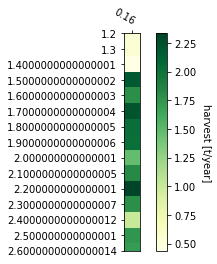

In [37]:
### your code here
def heatmap(data, row_labels, col_labels, cbar_kw = {}, ax, cbarlabel):
    im = ax.imshow(data, cmap="YlGn")
    # create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    # ticks
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    ax.tick_params(top=True, bottom=False,labeltop=True, labelbottom=False)
    # tick labels rotation
    plt.setp(ax.get_xticklabels(), rotation=-30)
    return im, cbar

fig, ax = plt.subplots()
im, cbar = heatmap(mse, spectral_radius, sparsity, ax=ax, cbarlabel="harvest [t/year]")

Optimal Prediction

In [ ]:
### your code here


<div class='exercise'><b> Question 2:   Long-range forecast  [50pts total] </b></div> 

Here you are asked to make a  long-range prediction. Use the first `50%` of your data to train the RC network and then predict the final `50%`. This is a very long prediction and, consequently, it is extremely hard. 

First, show that by using the RC as before, it is imposible to make a good prediction (with MSE smaller than 0.4). Make a grid search to check the lowest possible testing MSE.

Next, use the concept of the `observers` and perform an inference prediction. Follow the steps of the Question 1. Make a grid search in the hyperparameters `spectral-radius` and `sparsity`. Visualize the MSE in prediction by using a 2D plot.  Then perform a inference prediction with the optimal set. Plot the training and prediction along with the ground truth. Again, show the residuals.

Prepare your data: The target time-series should be splitted  into training and testing sets.

In [ ]:
### your code here


In [ ]:
### your code here


Hyperparameter Optimization

In [ ]:
### your code here


plot the results

In [ ]:
### your code here


#### Inference: Observers

Prepare your `observers`. The given `prepareData()` function does not prepare the observers, so you need to do it manually.

In [ ]:
### your code here


Make a quick prediction to see the improvement (without optimizing the hyper-parameters yet)

In [ ]:
### your code here


Hyper-parameter optimization

In [ ]:
### your code here


 Plot the results


In [ ]:
### your code here


Plot the optimal prediction (inference) here. As in Q1, show the fitting and prediction data along with the ground truth. And one, last time, plot the residuals.

In [ ]:
### your code here


## **References**

- https://github.com/cknd/pyESN
- https://github.com/FilippoMB/Reservoir-Computing-framework-for-multivariate-time-series-classification
- https://towardsdatascience.com/gentle-introduction-to-echo-state-networks-af99e5373c68


1. H. Jaeger and H. Haas. Harnessing Nonlinearity: Predicting Chaotic Systems and Saving Energy in Wireless Communication, Science **304**  (2004)
2. Z. Lu, J. Pathak, B. Hunt, M. Girvan, R. Brockett, and E. Ott. Reservoir observers: Model-free inference of unmeasured variables in chaotic systems, Chaos **27** (2017)
3. G. N. Neofotistos, M. Mattheakis, G. Barmparis, J. Hitzanidi, G. P. Tsironis, and E. Kaxiras. Machine learning with observers predicts complex spatiotemporal behavior. Front. Phys. - Quantum Computing **7** (2019)
